<a href="https://colab.research.google.com/github/ahmadcah/Hukumpedia/blob/master/Google_Colab/Prototype_Capstone_Project_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow.keras.utils as ku 
import numpy as np 
import re

In [10]:
with open('MergedData.txt', 'rb') as f:
  data = ''.join([x.decode('utf8') for x in f.readlines()])
  corpus = data.lower().split("\r\n")
  corpus = [re.sub('\d', '', y) for y in corpus]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
label = ku.to_categorical(label, num_classes=total_words)

In [ ]:
print(total_words)

In [ ]:
print(tokenizer.word_index)

In [13]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.96):
      print("\nReached 96% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [15]:
model = Sequential()
model.add(Embedding(total_words, 256, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Bidirectional(LSTM(256)))
model.add(Dropout(0.2))
model.add(Dense(total_words, activation='softmax'))
# Pick an optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 23, 256)           1992704   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 23, 512)           1050624   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               1574912   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7784)              3993192   
Total params: 8,611,432
Trainable params: 8,611,432
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
 history = model.fit(predictors, label, epochs=250, verbose=1, callbacks=[callbacks])

Epoch 1/250
3917/3917 [==============================] - 145s 34ms/step - loss: 6.1895 - accuracy: 0.0840
Epoch 2/250
3917/3917 [==============================] - 165s 42ms/step - loss: 5.4172 - accuracy: 0.1585
Epoch 3/250
3917/3917 [==============================] - 180s 46ms/step - loss: 5.0073 - accuracy: 0.1942
Epoch 4/250
3917/3917 [==============================] - 180s 46ms/step - loss: 4.7040 - accuracy: 0.2160
Epoch 5/250
3917/3917 [==============================] - 170s 44ms/step - loss: 4.4588 - accuracy: 0.2318
Epoch 6/250
3917/3917 [==============================] - 133s 34ms/step - loss: 4.2415 - accuracy: 0.2467
Epoch 7/250
3917/3917 [==============================] - 126s 32ms/step - loss: 4.0501 - accuracy: 0.2612
Epoch 8/250
3917/3917 [==============================] - 112s 29ms/step - loss: 3.8701 - accuracy: 0.2736
Epoch 9/250
3917/3917 [==============================] - 116s 30ms/step - loss: 3.7068 - accuracy: 0.2847
Epoch 10/250
3917/3917 [======================

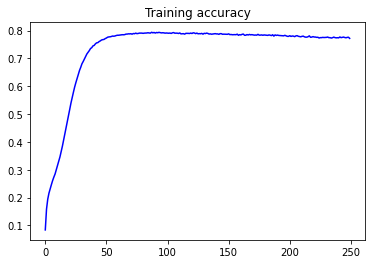

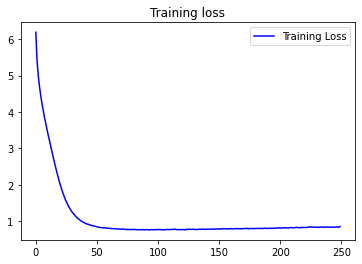

In [17]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [25]:
text = "bentuk"
print('input: '+text)
print('nomor itu accuracy')

token_list = tokenizer.texts_to_sequences([text])[0]
token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')

predictions = model.predict(token_list)

indices = np.argpartition(predictions, -5)[0][-5:]

results = {}
for index in indices:
  key = [k for (k, v) in tokenizer.word_index.items() if v == index]
  results.update({key[0]: predictions[0, index]})

  results = {k: v for k, v in sorted(results.items(), key=lambda item: item[1], reverse=True)}

print("{}".format(results))
for i in results:
  print(text+" "+i.)

input: bentuk
nomor itu accuracy
{'diskriminasi': 0.26111978, 'penganiayaan': 0.19067019, 'dan': 0.1872357, 'instrumennya': 0.07851881, 'pemerintahan': 0.069880046}
bentuk diskriminasi
bentuk penganiayaan
bentuk dan
bentuk instrumennya
bentuk pemerintahan


In [26]:
model.save('/content/saved_prototype_model/my_model')

INFO:tensorflow:Assets written to: /content/saved_prototype_model/my_model/assets


INFO:tensorflow:Assets written to: /content/saved_prototype_model/my_model/assets


In [27]:
model.save('/content/saved_prototype_model_HDF5/my_model.h5')

In [32]:
import pathlib

In [29]:
converter = tf.lite.TFLiteConverter.from_saved_model('/content/saved_prototype_model/my_model')
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

In [34]:
tflite_model_file = pathlib.Path('./modelSizeOptimize.tflite')
tflite_model_file.write_bytes(tflite_model)

8723616

In [35]:
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]
tflite_model = converter.convert()
tflite_model_file = pathlib.Path('./modelLatencyOptimize.tflite')
tflite_model_file.write_bytes(tflite_model)

8723616

In [36]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
tflite_model_file = pathlib.Path('./modelDefaultOptimize.tflite')
tflite_model_file.write_bytes(tflite_model)

8723616

In [37]:
!zip -r /content/Model.zip /content/Model

  adding: content/Model/ (stored 0%)
  adding: content/Model/saved_prototype_model/ (stored 0%)
  adding: content/Model/saved_prototype_model/my_model/ (stored 0%)
  adding: content/Model/saved_prototype_model/my_model/keras_metadata.pb (deflated 92%)
  adding: content/Model/saved_prototype_model/my_model/variables/ (stored 0%)
  adding: content/Model/saved_prototype_model/my_model/variables/variables.index (deflated 70%)
  adding: content/Model/saved_prototype_model/my_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/Model/saved_prototype_model/my_model/saved_model.pb (deflated 90%)
  adding: content/Model/saved_prototype_model/my_model/assets/ (stored 0%)
  adding: content/Model/saved_prototype_model_HDF5/ (stored 0%)
  adding: content/Model/saved_prototype_model_HDF5/my_model.h5 (deflated 8%)
